In [1]:
from stable_baselines3.sac.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import SAC
import logging
import gym
import numpy as np
import os

# add reference libraries here. Current structure will use the relative path from this file
libs = ["../../../OpenIPSL-1.5.0/OpenIPSL/package.mo",
       "../../../OpenIPSL-1.5.0/ApplicationExamples/IEEE9/package.mo"]

# check that all the paths to library package.mo files exist
# DymolaInterface() also checks this but I've found this warning helpful
for lib in libs:
    if not os.path.isfile(lib):
        print(f"Cannot find the library {lib}")

mo_name = "IEEE9.IEEE_9_wVariation" # name of Modelica model in the Library.Model format
env_entry_point = 'examples:IEEE9Env' # Python package location of RL environment

time_step = 1 # time delta in seconds
positive_reward = 1
negative_reward = -100 # penalize RL agent for is_done
log_level = 0
default_action = [0,0,0]

# these config values are passed to the model specific environment class
# mo_name and libs are passed on to the DymolaBaseEnv class
config = {
    'mo_name': mo_name,
    'libs': libs,
#     'actions': actions,
#     'states': states,
    'time_step': time_step,
    'positive_reward': positive_reward,
    'negative_reward': negative_reward,
    'log_level': log_level,
    'default_action': default_action,
    'method':'DASSL'
}

# enable the model specific class as an OpenAI gym environment
from gym.envs.registration import register
env_name = "MicrogridEnv-v1"

register(
    id=env_name,
    entry_point=env_entry_point,
    kwargs=config
)

In [2]:
# create the environment. this will run an initial step and must return [True, [...]] or something is broken
# TODO: create error handling/warnings if simulations don't work (i.e. returns [False], [...])
env = gym.make(env_name)
env.model_output_names += ['load_B5.variance.y']

resetting dymola...
dymola has been reset
the model will be reset
the model has been reset


C:\Users\Aisling\.conda\envs\myenv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


the model will be reset
the model has been reset
the model will be reset
the model has been reset
the model will be reset
the model has been reset


Text(0, 0.5, 'Variance Load 5 (p.u.)')

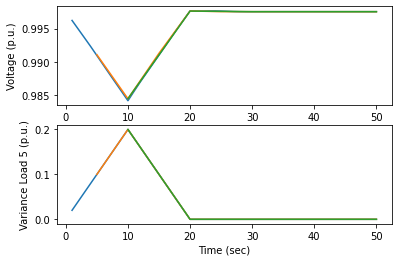

In [5]:
# show performance over 10 seconds in a do-nothing case (control voltage set at 1.0 pu)
# obs = env.reset()
sum_rewards = 0

import matplotlib.pyplot as plt
# plt = plt.plot()
fig, ax = plt.subplots(2)
env.model_output_names += ['B5.V']
env.model_output_names += ['load_B5.variance.y']
for ts in [1,5,10]:
    dn_voltage = []
    variance = []
    env.tau = ts
    env.reset()
    
    for i in range(int(50/ts)):
    #     print(i)
        action = [0,0,0] # weird behavior where the model thinks the action output by model.predict has len() = 2
        obs, reward, done, info = env.step(action)
    #     print(env.start)
    #     if done:
    #         env.reset()
        dn_voltage += [env.state[-2]]
#         print(env.state[:9])
        variance += [env.state[-1]]
        sum_rewards += reward

    # x-axis values 
    x = np.arange(int(50/ts))*env.tau+env.tau 
#     w = np.reshape(dn_voltage, (9,-1))[5,:]
    ax[0].plot(x,dn_voltage)
    ax[1].plot(x,variance)
# plt.plot(x,variance)
# plt.legend(['1sec', '5sec', '10sec'])
ax[1].set_xlabel('Time (sec)')
ax[0].set_ylabel('Voltage (p.u.)')
ax[1].set_ylabel('Variance Load 5 (p.u.)')
# plt.show()

In [ ]:
env.dymola.simulateExtendedModel(env.model_name, startTime=0, stopTime=0, finalNames=['load_B5.variance.period','load_B5.variance.nperiod'])

In [ ]:
for i in range(int(50/ts)):
#     print(i)
    action = [0,0,0] # weird behavior where the model thinks the action output by model.predict has len() = 2
    obs, reward, done, info = env.step(action)
#     print(env.start)
#     if done:
#         env.reset()
    dn_voltage += env.state[:9]
#     print(env.state[:9])
    variance += [env.state[-1]]
    sum_rewards += reward

In [ ]:
# show performance over 10 seconds in a do-nothing case (control voltage set at 1.0 pu)
# obs = env.reset()
sum_rewards = 0
env.method='Dassl'
env.model_output_names+=['B5.V']
import matplotlib.pyplot as plt
# plt = plt.plot()
fig, ax = plt.subplots(3,4, figsize=(24,24))
i = 0
j = 0
for i in range(1):
    timestep = [None, 0.01, 0.0001][i]
    env.fixedtimestep=timestep
    j = 0
    for j in range(4):
        ts = [1,5,10,25][j]
        dn_voltage = []
        variance = []
        env.tau = ts
        env.reset()

        for k in range(int(50/ts)):
        #     print(i)
            action = [0,0,0] # weird behavior where the model thinks the action output by model.predict has len() = 2
            obs, reward, done, info = env.step(action)
        #     print(env.start)
        #     if done:
        #         env.reset()
            dn_voltage += env.state[:-1]
    #         print(env.state[:9])
            variance += [env.state[-1]]
            sum_rewards += reward

    # x-axis values 
        x = np.arange(int(50/ts))*ts+ts
#         w = np.reshape(dn_voltage, (9,-1))
        ax[i][j].plot(x,dn_voltage)
        ax[i][j].set_title(f'fixedstepsize={timestep}, RL dt={ts}')
        
    # plt.plot(x,variance)
#     plt.legend(['1sec', '5sec', '10sec'])
plt.show()

In [ ]:
env.state

In [ ]:
# show performance over 10 seconds in a do-nothing case (control voltage set at 1.0 pu)
# obs = env.reset()
sum_rewards = 0
env.method='Euler'
import matplotlib.pyplot as plt
# plt = plt.plot()
fig, ax = plt.subplots(3,4, figsize=(24,24))
i = 0
j = 0
for i in range(1):
    timestep = [1][i]
    env.fixedtimestep=timestep
    j = 0
    for j in range(1):
        ts = [10][j]
        dn_voltage = []
        variance = []
        env.tau = ts
        env.reset()

        for k in range(int(50/ts)):
        #     print(i)
            action = [0,0,0] # weird behavior where the model thinks the action output by model.predict has len() = 2
            obs, reward, done, info = env.step(action)
        #     print(env.start)
        #     if done:
        #         env.reset()
            dn_voltage += env.state[:9]
    #         print(env.state[:9])
            variance += [env.state[-1]]
            sum_rewards += reward

    # x-axis values 
        x = np.arange(int(50/ts))*ts+ts
        w = np.reshape(dn_voltage, (9,-1))[5,:]
        ax[i][j].plot(x,w)
        ax[i][j].set_title(f'fixedstepsize={timestep}, RL dt={ts}')
        
    # plt.plot(x,variance)
#     plt.legend(['1sec', '5sec', '10sec'])
plt.show()